In [1]:
import pandas as pd

In [2]:
data= pd.read_csv('/content/AI.csv')
data.head()

,Question,Answer
0,Who did the first work generally recognized as...,Warren McCulloch and Walter Pitts (1943).\n
1,What sources was drawn on the formation of the...,knowledge of the basic physiology and function...
2,Who created the Hebbian learning rule?,Donald Hebb (1949).\n
3,When the first neural network is built?,1950.\n
4,What is the first neural network called?,The SNARC.\n


In [3]:
print(data.isnull().sum())
print('\n')
print(data.isnull().any())

Question    0
Answer      0
dtype: int64


Question    False
Answer      False
dtype: bool


In [4]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
import random
import json
import pickle
import numpy as np
import tensorflow as tf
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Extract questions and answers
questions = data['Question'].tolist()
answers = data['Answer'].tolist()

words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

for i in range(len(questions)):
    word_list = nltk.word_tokenize(questions[i])
    words.extend(word_list)
    documents.append((word_list, answers[i]))
    if answers[i] not in classes:
        classes.append(answers[i])

words = [lemmatizer.lemmatize(word) for word in words if word not in ignore_letters]
words = sorted(set(words))

classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

training = []
output_empty = [0] * len(classes)

for document in documents:
    bag = []
    word_patterns = document[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append(bag + output_row)

random.shuffle(training)
training = np.array(training)

train_X = training[:, :len(words)]
train_Y = training[:, len(words):]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(325, input_shape=(len(train_X[0]),), activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(len(train_Y[0]), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

hist = model.fit(np.array(train_X), np.array(train_Y), epochs=998, batch_size=32, verbose=1)
model.save('chatbot_mode2l.h5', hist)
print('Done')


Epoch 1/998
16/16 [==============================] - 1s 9ms/step - loss: 6.2038 - accuracy: 0.0040
Epoch 2/998
16/16 [==============================] - 0s 8ms/step - loss: 6.2050 - accuracy: 0.0040
Epoch 3/998
16/16 [==============================] - 0s 8ms/step - loss: 6.2018 - accuracy: 0.0040
Epoch 4/998
16/16 [==============================] - 0s 11ms/step - loss: 6.2004 - accuracy: 0.0020
Epoch 5/998
16/16 [==============================] - 0s 13ms/step - loss: 6.2000 - accuracy: 0.0099
Epoch 6/998
16/16 [==============================] - 0s 12ms/step - loss: 6.2027 - accuracy: 0.0020
Epoch 7/998
16/16 [==============================] - 0s 13ms/step - loss: 6.2011 - accuracy: 0.0040
Epoch 8/998
16/16 [==============================] - 0s 13ms/step - loss: 6.2001 - accuracy: 0.0040
Epoch 9/998
16/16 [==============================] - 0s 14ms/step - loss: 6.2012 - accuracy: 0.0020
Epoch 10/998
16/16 [==============================] - 0s 14ms/step - loss: 6.1993 - accuracy: 0.0040
Ep

<Axes: >

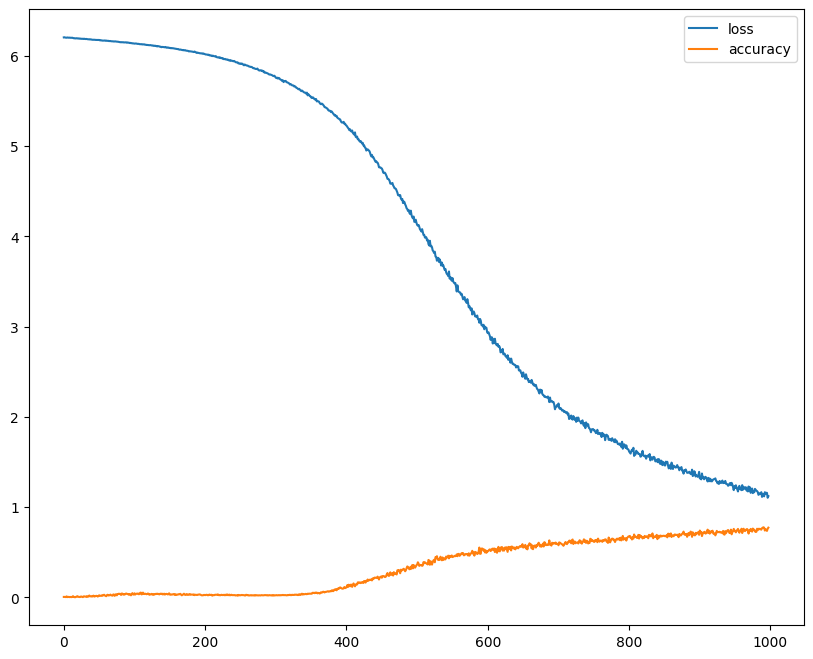

In [6]:
dn=pd.DataFrame(model.history.history)
dn.plot(figsize=(10,8))

In [7]:
print(data["Question"].iloc[0],"\n")
print(data["Question"].iloc[2],"\n")
print(data["Answer"].iloc[0],"\n")
print(data["Answer"].iloc[2],"\n")

Who did the first work generally recognized as AI? 

Who created the Hebbian learning rule? 

Warren McCulloch and Walter Pitts (1943).
 

Donald Hebb (1949).
 



In [9]:
import nltk
import numpy as np
import pickle
from keras.models import load_model

# Load the saved model and other necessary files
model = load_model('/content/chatbot_mode2l.h5')
words = pickle.load(open('words.pkl', 'rb'))
labels = pickle.load(open('/content/classes.pkl', 'rb'))

# Function to preprocess user input and get predictions
def bag_of_words(sentence, words):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]

    bag = [0] * len(words)
    for w in sentence_words:
        if w in words:
            bag[words.index(w)] = 1

    return np.array(bag)

def chat():
    print("Start talking with the bot (type 'quit' to stop)!")
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'quit':
            break

        user_input_bag = bag_of_words(user_input, words)
        user_input_bag = np.reshape(user_input_bag, (1, len(user_input_bag)))

        result = model.predict(user_input_bag)[0]
        index = np.argmax(result)

        if 0 <= index < len(labels):
            response_tag = labels[index]
            confidence_score = result[index]
            print(f"Predicted tag: {response_tag} (Confidence: {confidence_score:.2f})")
        else:
            print("Unknown response. Please rephrase.")

# Call the chat function to test the model
chat()


Start talking with the bot (type 'quit' to stop)!
You: Who did the first work generally recognized as AI 
1/1 [==============================] - 0s 95ms/step
Predicted tag: Warren McCulloch and Walter Pitts (1943).
 (Confidence: 0.93)
You: Who created the Hebbian learning rule
1/1 [==============================] - 0s 22ms/step
Predicted tag: Donald Hebb (1949).
 (Confidence: 0.70)
You: quit
